# How TextRank Works: A Visual Explanation

This notebook provides a step-by-step visual explanation of the TextRank algorithm. We'll trace through each stage of the algorithm to understand how keywords are extracted.

**Algorithm Overview:**
1. **Tokenization** - Break text into words with POS tags
2. **Co-occurrence Graph** - Build a graph connecting nearby words
3. **PageRank** - Iteratively compute word importance scores
4. **Phrase Extraction** - Group high-scoring words into keyphrases

In [1]:
# Install dependencies
%pip install -q rapid_textrank matplotlib networkx numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Built-in stopwords used by the native tokenizer
import rapid_textrank as rt

stopwords = rt.get_stopwords("en")
print(f"Built-in stopwords (en): {len(stopwords)}")
if len(stopwords) > 30:
    print(stopwords[:30])
else:
    print(stopwords)


Built-in stopwords (en): 1298
["'ll", "'tis", "'twas", "'ve", '10', '39', 'a', "a's", 'able', 'ableabout', 'about', 'above', 'abroad', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'ad', 'added', 'adj', 'adopted', 'ae', 'af', 'affected', 'affecting', 'affects', 'after']


In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from rapid_textrank import BaseTextRank, PositionRank, BiasedTextRank, TextRankConfig

In [4]:
# Our example text
text = """
Machine learning is a subset of artificial intelligence that enables
systems to learn and improve from experience. Deep learning, a type of
machine learning, uses neural networks with many layers.
"""

print("Sample text:")
print(text)

Sample text:

Machine learning is a subset of artificial intelligence that enables
systems to learn and improve from experience. Deep learning, a type of
machine learning, uses neural networks with many layers.



## Step 1: Tokenization

The first step is to break the text into tokens and identify their parts of speech. TextRank focuses on **content words** (nouns, verbs, adjectives) while filtering out stopwords and function words.

Above, we print the built-in stopword list used by the native tokenizer (you can extend it via config).

Let's simulate what rapid_textrank's built-in tokenizer produces:


In [5]:
# Simulated tokenization (rapid_textrank does this internally in Rust)
# We'll show a simplified version for educational purposes

tokens = [
    # Sentence 1
    {"text": "Machine", "lemma": "machine", "pos": "NOUN", "sentence_idx": 0, "is_stopword": False},
    {"text": "learning", "lemma": "learning", "pos": "NOUN", "sentence_idx": 0, "is_stopword": False},
    {"text": "is", "lemma": "be", "pos": "AUX", "sentence_idx": 0, "is_stopword": True},
    {"text": "a", "lemma": "a", "pos": "DET", "sentence_idx": 0, "is_stopword": True},
    {"text": "subset", "lemma": "subset", "pos": "NOUN", "sentence_idx": 0, "is_stopword": False},
    {"text": "of", "lemma": "of", "pos": "ADP", "sentence_idx": 0, "is_stopword": True},
    {"text": "artificial", "lemma": "artificial", "pos": "ADJ", "sentence_idx": 0, "is_stopword": False},
    {"text": "intelligence", "lemma": "intelligence", "pos": "NOUN", "sentence_idx": 0, "is_stopword": False},
    {"text": "that", "lemma": "that", "pos": "PRON", "sentence_idx": 0, "is_stopword": True},
    {"text": "enables", "lemma": "enable", "pos": "VERB", "sentence_idx": 0, "is_stopword": False},
    {"text": "systems", "lemma": "system", "pos": "NOUN", "sentence_idx": 0, "is_stopword": False},
    {"text": "to", "lemma": "to", "pos": "PART", "sentence_idx": 0, "is_stopword": True},
    {"text": "learn", "lemma": "learn", "pos": "VERB", "sentence_idx": 0, "is_stopword": False},
    {"text": "and", "lemma": "and", "pos": "CCONJ", "sentence_idx": 0, "is_stopword": True},
    {"text": "improve", "lemma": "improve", "pos": "VERB", "sentence_idx": 0, "is_stopword": False},
    {"text": "from", "lemma": "from", "pos": "ADP", "sentence_idx": 0, "is_stopword": True},
    {"text": "experience", "lemma": "experience", "pos": "NOUN", "sentence_idx": 0, "is_stopword": False},
    # Sentence 2
    {"text": "Deep", "lemma": "deep", "pos": "ADJ", "sentence_idx": 1, "is_stopword": False},
    {"text": "learning", "lemma": "learning", "pos": "NOUN", "sentence_idx": 1, "is_stopword": False},
    {"text": "a", "lemma": "a", "pos": "DET", "sentence_idx": 1, "is_stopword": True},
    {"text": "type", "lemma": "type", "pos": "NOUN", "sentence_idx": 1, "is_stopword": False},
    {"text": "of", "lemma": "of", "pos": "ADP", "sentence_idx": 1, "is_stopword": True},
    {"text": "machine", "lemma": "machine", "pos": "NOUN", "sentence_idx": 1, "is_stopword": False},
    {"text": "learning", "lemma": "learning", "pos": "NOUN", "sentence_idx": 1, "is_stopword": False},
    {"text": "uses", "lemma": "use", "pos": "VERB", "sentence_idx": 1, "is_stopword": False},
    {"text": "neural", "lemma": "neural", "pos": "ADJ", "sentence_idx": 1, "is_stopword": False},
    {"text": "networks", "lemma": "network", "pos": "NOUN", "sentence_idx": 1, "is_stopword": False},
    {"text": "with", "lemma": "with", "pos": "ADP", "sentence_idx": 1, "is_stopword": True},
    {"text": "many", "lemma": "many", "pos": "ADJ", "sentence_idx": 1, "is_stopword": True},
    {"text": "layers", "lemma": "layer", "pos": "NOUN", "sentence_idx": 1, "is_stopword": False},
]

# Display as a table
print(f"{'Token':<15} {'Lemma':<15} {'POS':<8} {'Stopword':<10} {'Content Word'}")
print("-" * 70)
for t in tokens:
    is_content = t['pos'] in ['NOUN', 'VERB', 'ADJ', 'PROPN'] and not t['is_stopword']
    marker = "✓" if is_content else ""
    print(f"{t['text']:<15} {t['lemma']:<15} {t['pos']:<8} {str(t['is_stopword']):<10} {marker}")

Token           Lemma           POS      Stopword   Content Word
----------------------------------------------------------------------
Machine         machine         NOUN     False      ✓
learning        learning        NOUN     False      ✓
is              be              AUX      True       
a               a               DET      True       
subset          subset          NOUN     False      ✓
of              of              ADP      True       
artificial      artificial      ADJ      False      ✓
intelligence    intelligence    NOUN     False      ✓
that            that            PRON     True       
enables         enable          VERB     False      ✓
systems         system          NOUN     False      ✓
to              to              PART     True       
learn           learn           VERB     False      ✓
and             and             CCONJ    True       
improve         improve         VERB     False      ✓
from            from            ADP      True       
experie

In [6]:
# Extract only content words (these will form graph nodes)
content_words = [t for t in tokens if t['pos'] in ['NOUN', 'VERB', 'ADJ', 'PROPN'] and not t['is_stopword']]

print(f"Content words ({len(content_words)} total):")
for i, w in enumerate(content_words):
    print(f"  {i+1:>2}. {w['lemma']} ({w['pos']})")

Content words (19 total):
   1. machine (NOUN)
   2. learning (NOUN)
   3. subset (NOUN)
   4. artificial (ADJ)
   5. intelligence (NOUN)
   6. enable (VERB)
   7. system (NOUN)
   8. learn (VERB)
   9. improve (VERB)
  10. experience (NOUN)
  11. deep (ADJ)
  12. learning (NOUN)
  13. type (NOUN)
  14. machine (NOUN)
  15. learning (NOUN)
  16. use (VERB)
  17. neural (ADJ)
  18. network (NOUN)
  19. layer (NOUN)


## Step 2: Co-occurrence Graph

TextRank builds an **undirected graph** where:
- **Nodes** = Content words (lemmas)
- **Edges** = Words that appear near each other (within a sliding window)

The `window_size` parameter controls how far apart words can be to still be connected.

In [7]:
def build_cooccurrence_graph(tokens, window_size=3):
    """Build a co-occurrence graph from tokens."""
    G = nx.Graph()
    
    # Filter to content words only
    content_words = [t for t in tokens if t['pos'] in ['NOUN', 'VERB', 'ADJ', 'PROPN'] and not t['is_stopword']]
    
    # Add all nodes
    for word in content_words:
        G.add_node(word['lemma'])
    
    # Add edges for words within window (same sentence)
    for i, word_i in enumerate(content_words):
        for j in range(i + 1, min(i + window_size, len(content_words))):
            word_j = content_words[j]
            # Only connect words in the same sentence
            if word_i['sentence_idx'] == word_j['sentence_idx']:
                lemma_i, lemma_j = word_i['lemma'], word_j['lemma']
                if G.has_edge(lemma_i, lemma_j):
                    G[lemma_i][lemma_j]['weight'] += 1
                else:
                    G.add_edge(lemma_i, lemma_j, weight=1)
    
    return G

# Build graph with default window size
G = build_cooccurrence_graph(tokens, window_size=3)

print(f"Graph Statistics:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")


Graph Statistics:
  Nodes: 16
  Edges: 29


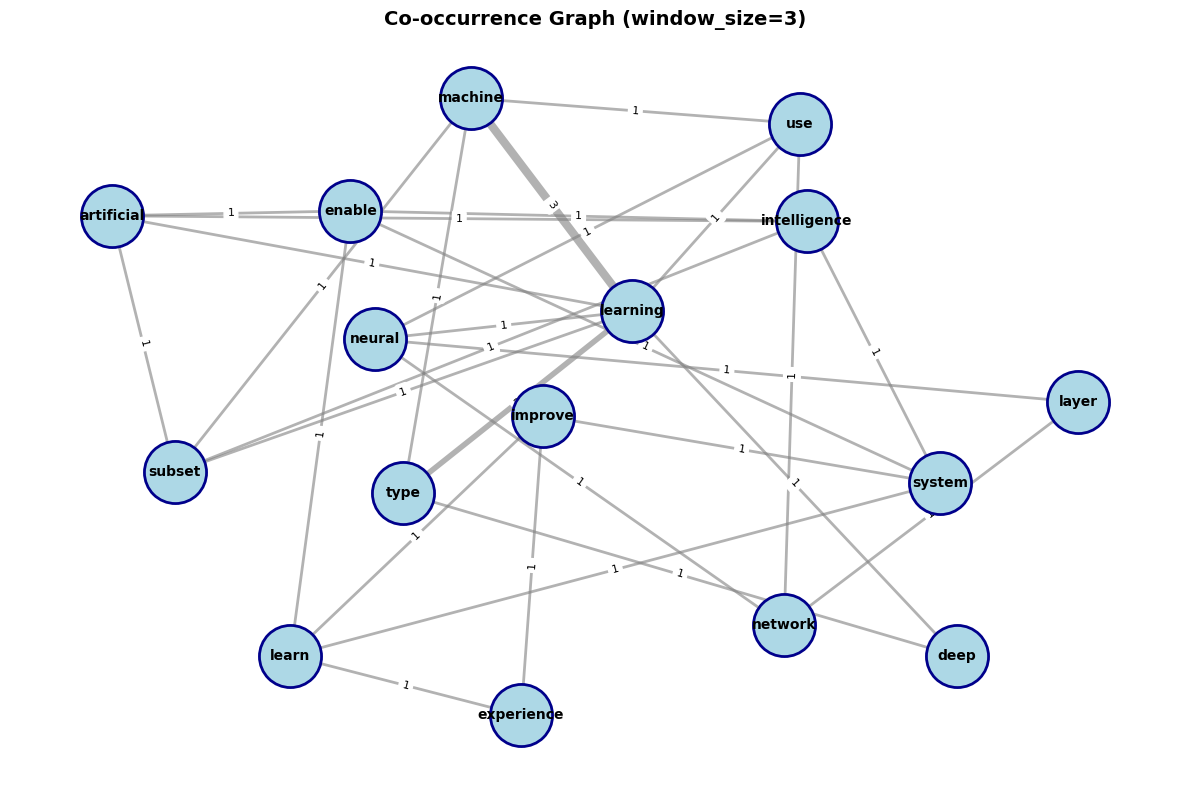

In [8]:
# Visualize the co-occurrence graph
fig, ax = plt.subplots(figsize=(12, 8))

# Use spring layout for nice visualization
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Draw edges with width proportional to weight
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w * 2 for w in edge_weights], 
                       alpha=0.6, edge_color='gray', ax=ax)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', 
                       edgecolors='darkblue', linewidths=2, ax=ax)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)

# Draw edge labels (weights)
edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8, ax=ax)

ax.set_title("Co-occurrence Graph (window_size=3)", fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()


### Effect of Window Size

The `window_size` parameter affects how connected the graph is:
- **Smaller window** (2-3): Only very close words are connected
- **Larger window** (6-8): More connections, captures broader relationships

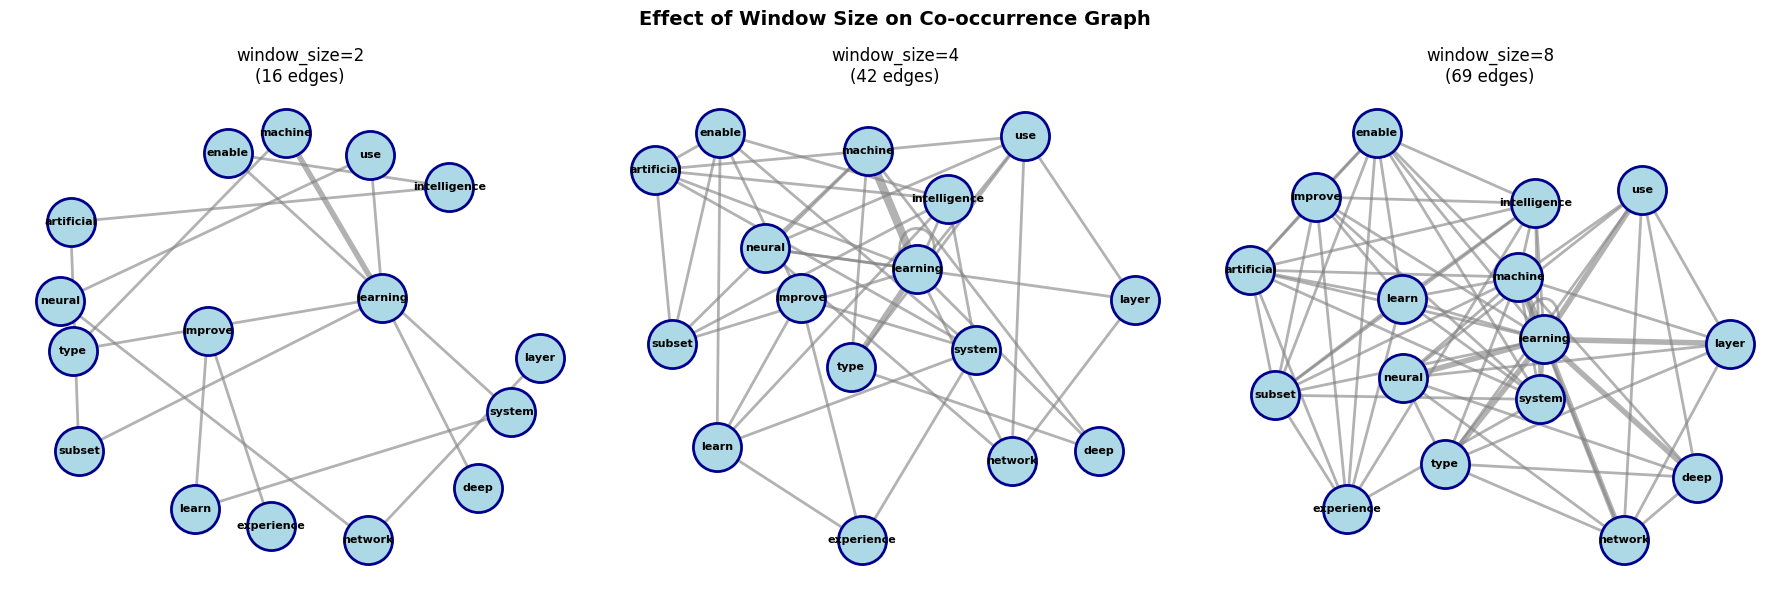

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
window_sizes = [2, 4, 8]

for ax, ws in zip(axes, window_sizes):
    G = build_cooccurrence_graph(tokens, window_size=ws)
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=[w * 2 for w in edge_weights], 
                           alpha=0.6, edge_color='gray', ax=ax)
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color='lightblue', 
                           edgecolors='darkblue', linewidths=2, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)
    
    ax.set_title(f"window_size={ws}\n({G.number_of_edges()} edges)", fontsize=12)
    ax.axis('off')

plt.suptitle("Effect of Window Size on Co-occurrence Graph", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 3: PageRank

PageRank is an iterative algorithm that distributes "importance" through the graph:

1. Start with equal scores for all nodes
2. Each iteration: redistribute scores based on connections
3. Repeat until scores converge (change less than threshold)

The **damping factor** (default 0.85) controls how much score "leaks" vs. stays in the graph.

In [10]:
def pagerank_with_history(G, damping=0.85, max_iterations=100, tol=1e-6):
    """Run PageRank and track score evolution."""
    N = len(G)
    if N == 0:
        return {}, []
    
    # Initialize equal scores
    scores = {node: 1.0 / N for node in G.nodes()}
    history = [dict(scores)]  # Track each iteration
    
    for iteration in range(max_iterations):
        new_scores = {}
        for node in G.nodes():
            # Sum contributions from neighbors
            rank_sum = 0
            for neighbor in G.neighbors(node):
                neighbor_degree = G.degree(neighbor)
                if neighbor_degree > 0:
                    rank_sum += scores[neighbor] / neighbor_degree
            
            # Apply damping factor
            new_scores[node] = (1 - damping) / N + damping * rank_sum
        
        # Check convergence
        diff = sum(abs(new_scores[n] - scores[n]) for n in G.nodes())
        scores = new_scores
        history.append(dict(scores))
        
        if diff < tol:
            break
    
    return scores, history

# Run PageRank
G = build_cooccurrence_graph(tokens, window_size=3)
scores, history = pagerank_with_history(G)

print(f"PageRank converged in {len(history)-1} iterations")
print(f"\nFinal scores (sorted by importance):")
for word, score in sorted(scores.items(), key=lambda x: -x[1]):
    print(f"  {word:<15} {score:.4f}")


PageRank converged in 29 iterations

Final scores (sorted by importance):
  learning        0.1112
  learn           0.0713
  neural          0.0700
  system          0.0687
  use             0.0675
  enable          0.0668
  machine         0.0660
  intelligence    0.0657
  artificial      0.0648
  subset          0.0646
  improve         0.0563
  network         0.0556
  type            0.0530
  experience      0.0405
  layer           0.0400
  deep            0.0379


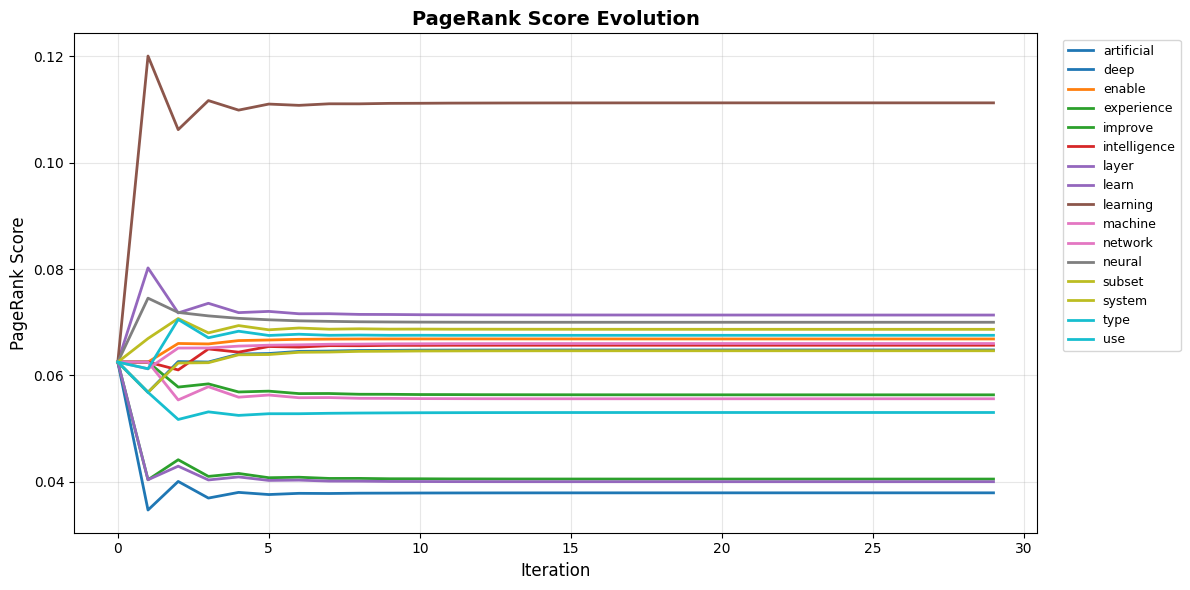

In [11]:
# Visualize score evolution over iterations
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each word's score over time
iterations = range(len(history))
colors = plt.cm.tab10(np.linspace(0, 1, len(G.nodes())))

for (word, color) in zip(sorted(G.nodes()), colors):
    word_scores = [h[word] for h in history]
    ax.plot(iterations, word_scores, label=word, color=color, linewidth=2)

ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("PageRank Score", fontsize=12)
ax.set_title("PageRank Score Evolution", fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

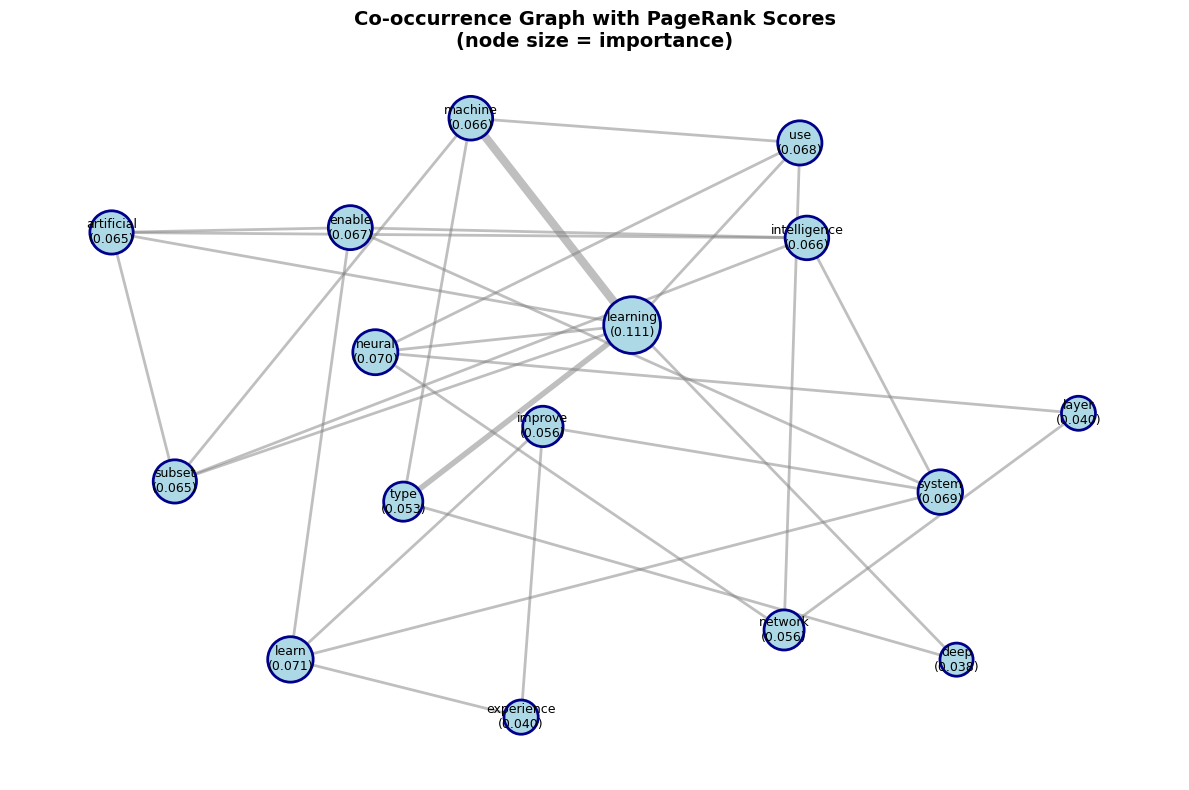

In [12]:
# Visualize graph with node size proportional to score
fig, ax = plt.subplots(figsize=(12, 8))

G = build_cooccurrence_graph(tokens, window_size=3)
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Node sizes based on PageRank scores
node_sizes = [scores[node] * 15000 for node in G.nodes()]

# Edge weights
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w * 2 for w in edge_weights], 
                       alpha=0.5, edge_color='gray', ax=ax)

# Draw nodes with size = importance
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', 
                       edgecolors='darkblue', linewidths=2, ax=ax)

# Labels with scores
labels = {n: f"{n}\n({scores[n]:.3f})" for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=9, ax=ax)

ax.set_title("Co-occurrence Graph with PageRank Scores\n(node size = importance)", 
             fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()


### Effect of Damping Factor

The damping factor controls how much importance is distributed vs. retained:
- **Low damping (0.5)**: More uniform distribution, less differentiation
- **High damping (0.95)**: More influenced by graph structure

In [13]:
damping_values = [0.5, 0.85, 0.95]

print("Effect of Damping Factor:")
print("=" * 60)

for d in damping_values:
    scores, _ = pagerank_with_history(G, damping=d)
    top_words = sorted(scores.items(), key=lambda x: -x[1])[:5]
    
    print(f"\nDamping = {d}:")
    for word, score in top_words:
        print(f"  {word:<15} {score:.4f}")

Effect of Damping Factor:

Damping = 0.5:
  learning        0.0925
  learn           0.0701
  neural          0.0684
  system          0.0660
  use             0.0644

Damping = 0.85:
  learning        0.1112
  learn           0.0713
  neural          0.0700
  system          0.0687
  use             0.0675

Damping = 0.95:
  learning        0.1172
  learn           0.0702
  neural          0.0694
  system          0.0691
  use             0.0684


## Step 4: Phrase Extraction

After computing word scores, TextRank extracts **phrases** by:
1. Finding sequences of content words
2. Aggregating their PageRank scores (sum, mean, max, or RMS)
3. Ranking phrases by aggregated score

Let's see how rapid_textrank performs the full extraction:

In [14]:
# Run rapid_textrank (the complete algorithm)
extractor = BaseTextRank(top_n=10, language="en")
result = extractor.extract_keywords(text)

print("Final Extracted Phrases:")
print("=" * 50)
for p in result.phrases:
    print(f"{p.rank:>2}. {p.text:<30} score={p.score:.4f}")

Final Extracted Phrases:
 1. neural networks                score=0.1375
 2. artificial intelligence        score=0.1354
 3. subset                         score=0.0754
 4. improve                        score=0.0738
 5. learn                          score=0.0738
 6. experience                     score=0.0512
 7. systems                        score=0.0512
 8. Deep                           score=0.0435
 9. type                           score=0.0435
10. layers                         score=0.0428


In [15]:
# Compare aggregation methods
aggregation_methods = ["sum", "mean", "max", "rms"]

print("Score Aggregation Comparison:")
print("=" * 70)

for method in aggregation_methods:
    config = TextRankConfig(score_aggregation=method, top_n=5, language="en")
    extractor = BaseTextRank(config=config)
    result = extractor.extract_keywords(text)
    
    print(f"\n{method.upper()} aggregation:")
    for p in result.phrases:
        print(f"  {p.text:<30} {p.score:.4f}")

Score Aggregation Comparison:

SUM aggregation:
  neural networks                0.1375
  artificial intelligence        0.1354
  subset                         0.0754
  improve                        0.0738
  learn                          0.0738

MEAN aggregation:
  subset                         0.0754
  improve                        0.0738
  learn                          0.0738
  neural networks                0.0687
  artificial intelligence        0.0677

MAX aggregation:
  neural networks                0.0778
  artificial intelligence        0.0759
  subset                         0.0754
  improve                        0.0738
  learn                          0.0738

RMS aggregation:
  subset                         0.0754
  improve                        0.0738
  learn                          0.0738
  neural networks                0.0693
  artificial intelligence        0.0682


## PositionRank Visualization

PositionRank assigns higher initial weights to words appearing early in the document. Let's visualize these position weights:

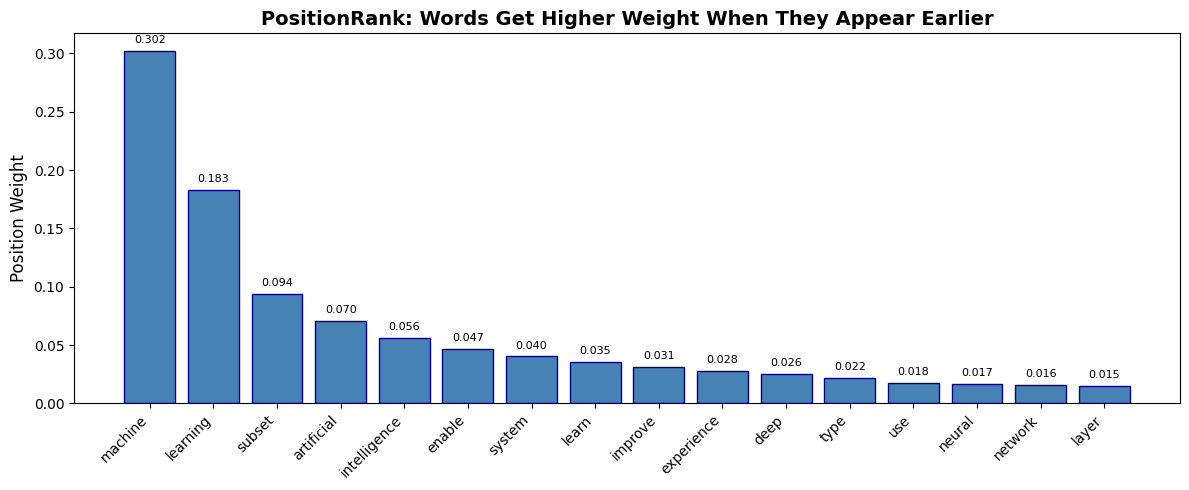

In [16]:
# Calculate position weights (inverse position)
content_words = [t for t in tokens if t['pos'] in ['NOUN', 'VERB', 'ADJ', 'PROPN'] and not t['is_stopword']]

# PositionRank uses inverse position as weight
position_weights = {}
for i, word in enumerate(content_words):
    lemma = word['lemma']
    # Sum inverse positions for repeated words
    weight = 1.0 / (i + 1)
    position_weights[lemma] = position_weights.get(lemma, 0) + weight

# Normalize
total = sum(position_weights.values())
position_weights = {k: v/total for k, v in position_weights.items()}

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))

words = list(position_weights.keys())
weights = list(position_weights.values())

bars = ax.bar(range(len(words)), weights, color='steelblue', edgecolor='darkblue')
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation=45, ha='right', fontsize=10)
ax.set_ylabel("Position Weight", fontsize=12)
ax.set_title("PositionRank: Words Get Higher Weight When They Appear Earlier", 
             fontsize=14, fontweight='bold')

# Add value labels
for bar, weight in zip(bars, weights):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            f'{weight:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [17]:
# Compare BaseTextRank vs PositionRank
base = BaseTextRank(top_n=5, language="en")
pos = PositionRank(top_n=5, language="en")

base_result = base.extract_keywords(text)
pos_result = pos.extract_keywords(text)

print(f"{'BaseTextRank':<30} {'PositionRank':<30}")
print("=" * 60)
for i in range(5):
    base_p = f"{base_result.phrases[i].text} ({base_result.phrases[i].score:.3f})"
    pos_p = f"{pos_result.phrases[i].text} ({pos_result.phrases[i].score:.3f})"
    print(f"{base_p:<30} {pos_p:<30}")

BaseTextRank                   PositionRank                  
neural networks (0.137)        artificial intelligence (0.164)
artificial intelligence (0.135) subset (0.116)                
subset (0.075)                 neural networks (0.115)       
improve (0.074)                Machine (0.103)               
learn (0.074)                  enables (0.046)               


## BiasedTextRank Visualization

BiasedTextRank gives initial boost to specified focus terms, causing related words to rank higher:

In [18]:
# Text with multiple topics
multi_topic_text = """
Modern web applications must balance user experience with security.
Performance optimizations are crucial for mobile users on slow networks.
Privacy regulations like GDPR require careful data handling.
Security vulnerabilities can expose sensitive user information.
"""

focus_terms = ["security", "privacy"]

# Highlight which words are focus terms
print("Focus terms highlighted in text:")
highlighted = multi_topic_text
for term in focus_terms:
    highlighted = highlighted.replace(term, f"**{term.upper()}**")
    highlighted = highlighted.replace(term.capitalize(), f"**{term.upper()}**")
print(highlighted)

Focus terms highlighted in text:

Modern web applications must balance user experience with **SECURITY**.
Performance optimizations are crucial for mobile users on slow networks.
**PRIVACY** regulations like GDPR require careful data handling.
**SECURITY** vulnerabilities can expose sensitive user information.



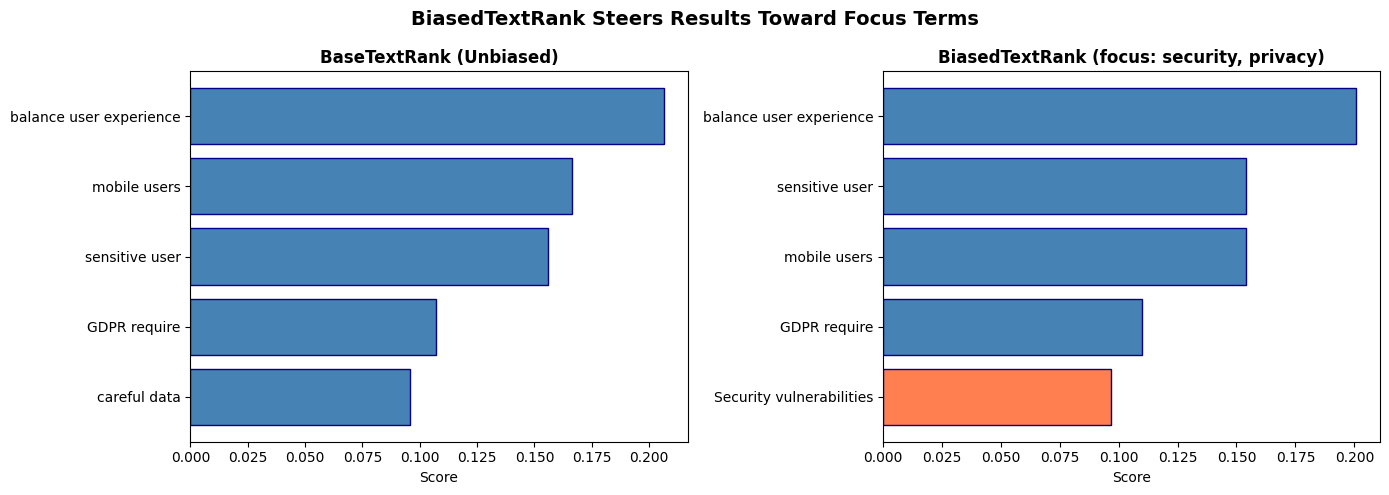

In [19]:
# Compare unbiased vs biased
base = BaseTextRank(top_n=5, language="en")
biased = BiasedTextRank(
    focus_terms=["security", "privacy"],
    bias_weight=5.0,
    top_n=5,
    language="en"
)

base_result = base.extract_keywords(multi_topic_text)
biased_result = biased.extract_keywords(multi_topic_text)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Unbiased
texts = [p.text for p in base_result.phrases]
scores = [p.score for p in base_result.phrases]
colors = ['steelblue'] * len(texts)
axes[0].barh(range(len(texts)), scores, color=colors, edgecolor='darkblue')
axes[0].set_yticks(range(len(texts)))
axes[0].set_yticklabels(texts)
axes[0].invert_yaxis()
axes[0].set_xlabel("Score")
axes[0].set_title("BaseTextRank (Unbiased)", fontsize=12, fontweight='bold')

# Biased
texts = [p.text for p in biased_result.phrases]
scores = [p.score for p in biased_result.phrases]
# Highlight focus-related terms
colors = ['coral' if any(f in t.lower() for f in focus_terms) else 'steelblue' for t in texts]
axes[1].barh(range(len(texts)), scores, color=colors, edgecolor='darkblue')
axes[1].set_yticks(range(len(texts)))
axes[1].set_yticklabels(texts)
axes[1].invert_yaxis()
axes[1].set_xlabel("Score")
axes[1].set_title("BiasedTextRank (focus: security, privacy)", fontsize=12, fontweight='bold')

plt.suptitle("BiasedTextRank Steers Results Toward Focus Terms", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary

TextRank is an elegant algorithm that leverages graph theory for keyword extraction:

1. **Tokenization**: Extract content words (nouns, verbs, adjectives)
2. **Co-occurrence Graph**: Connect words that appear near each other
3. **PageRank**: Iteratively compute word importance scores
4. **Phrase Extraction**: Group and rank high-scoring words

**Variants** modify this basic process:
- **PositionRank**: Boosts early-appearing words
- **BiasedTextRank**: Steers results toward focus terms

**Key parameters** affecting results:
- `window_size`: How far apart words can be to connect (default: 4)
- `damping`: PageRank damping factor (default: 0.85)
- `score_aggregation`: How to combine word scores (sum, mean, max, rms)

## Next Steps

- **[04_benchmarks.ipynb](04_benchmarks.ipynb)** - See how rapid_textrank's Rust implementation compares to pytextrank